##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention



Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).



In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [4]:
tf.__version__

'2.3.0'

In [5]:
# PATH = "/content/drive/My Drive/img_caption/clean_data"

In [6]:
PATH= "/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic"

## Read annotation json file 

In [7]:
# # Read the json file
# with open(PATH + "/6_merapi_park.json", 'r') as f:
#     anot_6_merapi_park = json.load(f)

# # Read the json file
# with open(PATH + "/7_air_terjun_sri_getuk.json", 'r') as f:
#     anot_7_air_terjun_sri_getuk = json.load(f)

# # Read the json file
# with open(PATH + "/8_parangtritis.json", 'r') as f:
#     anot_8_parangtritis = json.load(f)

# # Read the json file
# with open(PATH + "/9_hutan_pinus.json", 'r') as f:
#     anot_9_hutan_pinus = json.load(f)

# # Read the json file
# with open(PATH + "/10_bukit_paralayang.json", 'r') as f:
#     anot_10_bukit_paralayang = json.load(f)

# # Read the json file
# with open(PATH + "/11_heha_sky_view.json", 'r') as f:
#     anot_11_heha_sky_view = json.load(f)

# # Read the json file
# with open(PATH + "/12_ayunan_langit_watu_jaran.json", 'r') as f:
#     anot_12_ayunan_langit_watu_jaran = json.load(f)

# # Read the json file
# with open(PATH + "/all_caption.json", 'r') as f:
#     anot_all_caption = json.load(f)
    
# 6_merapi_park.json
# 7_air_terjun_sri_getuk.json
# 8_parangtritis.json
# 9_hutan_pinus.json
# 10_bukit_paralayang.json
# 11_heha_sky_view.json
# 12_ayunan_langit_watu_jaran.json

# all_caption.json

In [8]:
# print(len(anot_6_merapi_park))
# print(len(anot_7_air_terjun_sri_getuk))
# print(len(anot_8_parangtritis))
# print(len(anot_9_hutan_pinus))
# print(len(anot_10_bukit_paralayang))
# print(len(anot_11_heha_sky_view))
# print(len(anot_12_ayunan_langit_watu_jaran))
# print(len(anot_all_caption))

In [9]:
# annotations = anot_6_merapi_park + anot_7_air_terjun_sri_getuk + \
# anot_8_parangtritis + anot_9_hutan_pinus + anot_10_bukit_paralayang + \
# anot_11_heha_sky_view + anot_12_ayunan_langit_watu_jaran + anot_all_caption

In [10]:
# with open(PATH + "/all_caption.json", 'w') as fp:
#     json.dump(annotations, fp)

In [11]:
with open(PATH + "/all_caption.json", 'r') as f:
    annotations = json.load(f)

In [12]:
len(annotations)

1201

In [13]:
annotations[:10]

[{'caption': 'banyak jenis bunga di merapi park',
  'image_id': '0cv1krzup6x45sq3i8hb.jpg'},
 {'caption': 'banyak jenis bunga di merapi park',
  'image_id': '0jcymwz1atpn2fhi6s54.jpg'},
 {'caption': 'tempat cukup luas dan pemandangan yang membuat tidak ingin pulang',
  'image_id': '0y6txkj1b7eqmw9gpunc.jpg'},
 {'caption': 'tempat cukup luas dan pemandangan yang membuat tidak ingin pulang',
  'image_id': '1ho0rsaj76pnl4muibzy.jpg'},
 {'caption': 'banyak jenis bunga di merapi park',
  'image_id': '2b8e76qsg34umi9lxktc.jpg'},
 {'caption': 'ingin lihat miniatur wisata diberbagai belahan dunia yuk ke merapi park',
  'image_id': '2ziuvk0d9aylptscgxj3.jpg'},
 {'caption': 'cocok untuk liburan bersama keluarga',
  'image_id': '3mu6nrfa841hwjbp9507.jpg'},
 {'caption': 'bagi ingin berfoto bersama kekasih sangat sesuai',
  'image_id': '3zaemw08qpghy27fbdv4.jpg'},
 {'caption': 'bagi ingin berfoto bersama kekasih sangat sesuai',
  'image_id': '4kbys2n1x7ovi9drepl5.jpg'},
 {'caption': 'bagi ingin ber

In [14]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_image_path = PATH + '/dataset_inception_v3/' + '{IMG}'.format(IMG=image_id)
    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# num_examples = 480
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

In [15]:
train_captions[:10]

['<start> berayun dan melihat pemandangan di ayunan langit watu jaran <end>',
 '<start> banyak tumbuhan dibawahnya <end>',
 '<start> bermain air juga sangat menyenangkan <end>',
 '<start> pemandangan yang menawan dari bukit paralayang <end>',
 '<start> serunya arung jeram <end>',
 '<start> serunya arung jeram <end>',
 '<start> menikmati ombak dan angin di pantai parangtritis <end>',
 '<start> ibu-ibu sedang menaiki becak di malioboro <end>',
 '<start> bermain air juga sangat menyenangkan <end>',
 '<start> pemandangan yang menawan dari bukit paralayang <end>']

In [16]:
img_name_vector[:10]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/a7tcz1l0rkojxv3sf4em.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/3p1cgrahe4qitw0kf6du.jpeg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/hz7aenruy2ogm5f3ktiw.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/n9df1iy70p8ljverh4tz.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/9bli6p2ya58udrc01fh3.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/0kfe159hl6dt8yzwsn3o.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/3m9ju6kr2sdegbyn7fz5.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/Jalan-Malioboro-2.jpg',
 '/home/yurio/mainan_yurio/img_cap

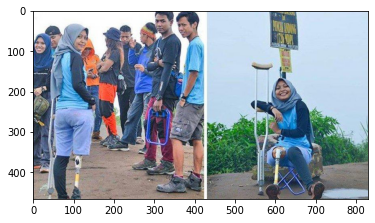

<start> potret pendaki cantik di atas gunung <end>
(466, 830, 3)
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [210 227 245]
  [210 227 245]
  [210 227 245]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [210 227 245]
  [210 227 245]
  [211 228 246]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [211 228 246]
  [211 228 246]
  [212 229 247]]

 ...

 [[161 149 135]
  [165 153 139]
  [168 156 142]
  ...
  [108 117 114]
  [110 119 116]
  [112 121 118]]

 [[164 147 139]
  [166 149 141]
  [166 149 141]
  ...
  [111 115 114]
  [111 115 114]
  [111 115 116]]

 [[164 147 139]
  [166 149 141]
  [166 149 141]
  ...
  [116 120 119]
  [115 119 118]
  [115 119 120]]]


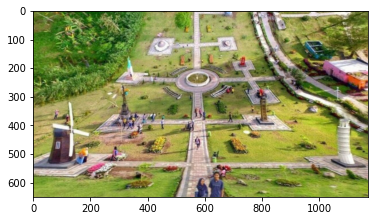

<start> banyak jenis bunga di merapi park <end>
(650, 1170, 3)
[[[113 130  50]
  [114 131  51]
  [116 133  53]
  ...
  [103 118  49]
  [109 120  51]
  [109 120  51]]

 [[113 130  50]
  [114 131  51]
  [113 130  50]
  ...
  [101 116  47]
  [108 119  50]
  [108 119  50]]

 [[113 130  50]
  [113 130  50]
  [111 128  48]
  ...
  [ 94 109  40]
  [100 113  43]
  [100 113  43]]

 ...

 [[153 167  70]
  [154 168  71]
  [157 171  74]
  ...
  [132 142  56]
  [126 140  55]
  [126 140  55]]

 [[160 171  75]
  [160 171  75]
  [161 172  76]
  ...
  [140 150  63]
  [139 153  66]
  [139 153  66]]

 [[162 173  77]
  [162 173  77]
  [162 173  77]
  ...
  [143 156  66]
  [141 157  68]
  [141 157  68]]]


In [17]:
%matplotlib inline
import matplotlib.image as mpimg
img=mpimg.imread(img_name_vector[1200])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[1200])
print(img.shape)
print(img)

img=mpimg.imread(img_name_vector[121])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[121])
print(img.shape)
print(img)

In [18]:
len(train_captions), len(all_captions)

(1201, 1201)

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [20]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (224, 224))
#     img = tf.keras.applications.vgg16.preprocess_input(img)
#     return img, image_path

In [21]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (224, 224))
#     img = tf.keras.applications.efficientnet.preprocess_input(img)
#     return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.

#### help(tf.keras.Model)

`Model` groups layers into an object with training and inference features.
There are two ways to instantiate a `Model`:

1. With the "functional API", where you start from `Input`,
you chain layer calls to specify the model's forward pass,
and finally you create your model from inputs and outputs:

### it's use this form
```python
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# tf.keras.applications.InceptionV3(weights='imagenet').summary()
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# image_features_extract_model # image features extractor

image_features_extract_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
# image_model = tf.keras.applications.VGG16(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# image_features_extract_model.summary()

# tf.keras.applications.VGG16(weights='imagenet').summary()



In [24]:
# image_model = tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet')
#
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# image_features_extract_model.summary()

# tf.keras.applications.EfficientNetB0(weights='imagenet').summary()



## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [25]:
# !pip install tqdm

In [26]:
from tqdm import tqdm

In [27]:
# Get unique images
encode_train = sorted(set(img_name_vector))

In [28]:
len(encode_train) # 

1201

In [29]:
encode_train[:5]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/021u3yagso4qhwxndkbf.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/02jsutdihcmo58exvz7q.jpeg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/04z6v1thy3xomadl5s7i.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/05s1uyjav6hzm3g7rfit.png',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/06kzxd92bc5h78g3lijr.jpeg']

In [30]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [31]:
image_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [32]:
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) # map functional programming


In [33]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [34]:
# for files_img_dtst in image_dataset: 
#     print(files_img_dtst)

In [35]:
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img) # image features extractor model
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path): # bf : batch feature , p : path
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())
# - `store the resulting vector` `in a dictionary` (image_name --> feature_vector).
# - you pickle the dictionary and save it to disk.

In [36]:
np_img =np.load('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/04z6v1thy3xomadl5s7i.jpg.npy')

print(np_img)
print("Shape : {}".format(np_img.shape))

[[0.         0.21677916 1.7954658  ... 0.69974416 0.         0.        ]
 [0.         0.         0.6632559  ... 0.8791829  0.         0.        ]
 [0.         0.         0.         ... 1.1342603  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.3641189 ]
 [0.         0.         0.73481566 ... 0.         0.         0.06842759]
 [0.         0.         0.3718581  ... 0.         0.         0.        ]]
Shape : (64, 2048)


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [37]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [38]:
import pandas as pd

In [39]:
dict_df = {"filename":img_name_vector,"caption":train_captions}

In [40]:
df = pd.DataFrame(dict_df)

In [41]:
for i, v in enumerate(df.values) :
    print(i, v)
    if i == 2:
        break

0 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/a7tcz1l0rkojxv3sf4em.jpg'
 '<start> berayun dan melihat pemandangan di ayunan langit watu jaran <end>']
1 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/3p1cgrahe4qitw0kf6du.jpeg'
 '<start> banyak tumbuhan dibawahnya <end>']
2 ['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/hz7aenruy2ogm5f3ktiw.jpg'
 '<start> bermain air juga sangat menyenangkan <end>']


In [42]:
from collections import Counter

In [43]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
#   print("We can see that all the keys are having values count = 5")
  print(ct_dict)

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [44]:
unique_filenames = utility_counter(df)

The number of unique file names : 1201
Counter({'/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/a7tcz1l0rkojxv3sf4em.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/3p1cgrahe4qitw0kf6du.jpeg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/hz7aenruy2ogm5f3ktiw.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/n9df1iy70p8ljverh4tz.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/9bli6p2ya58udrc01fh3.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/0kfe159hl6dt8yzwsn3o.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/3m9ju6kr2sdegbyn7fz5.jpg': 1, '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_

In [45]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

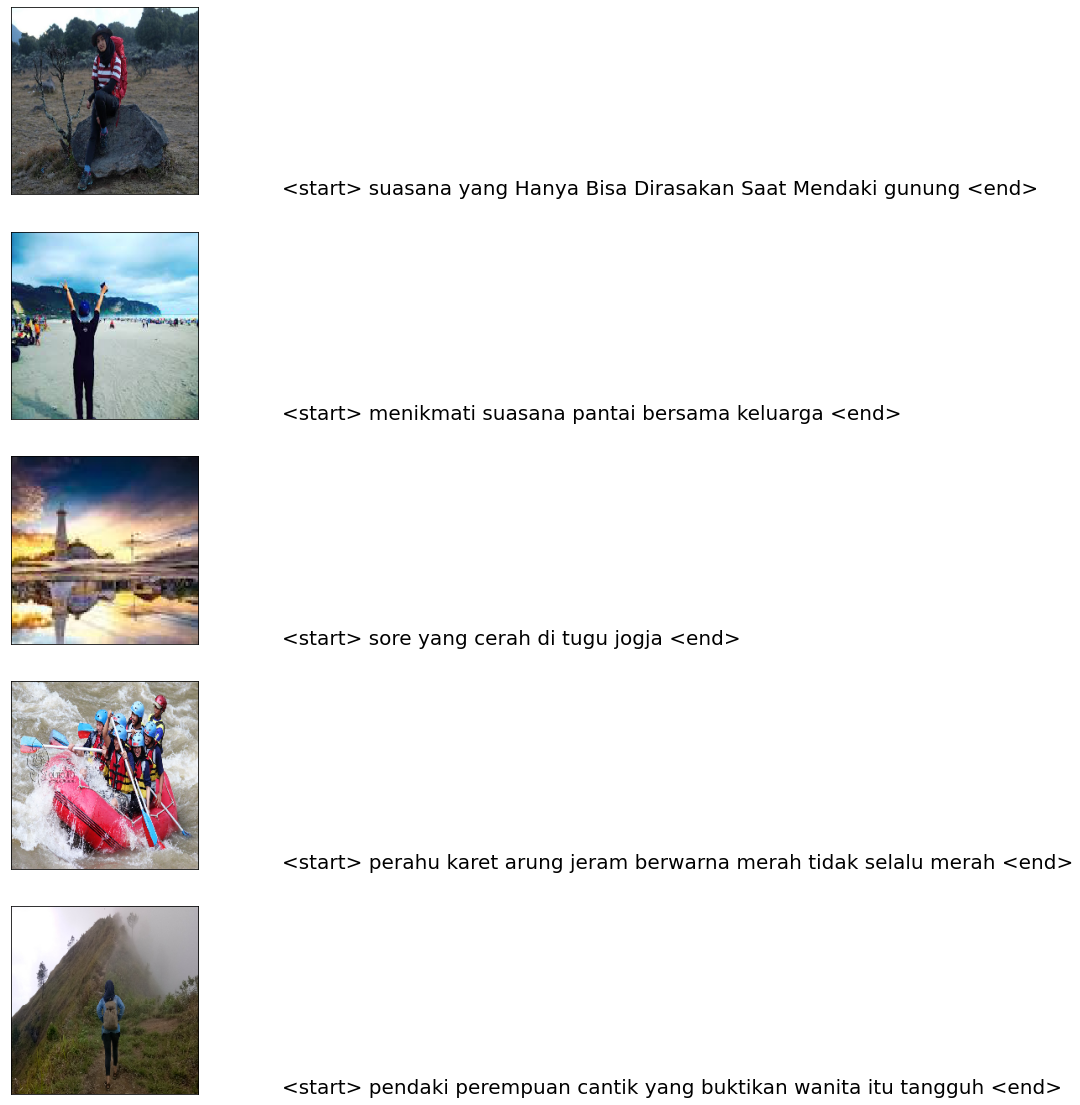

In [46]:
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[20:25]:
      filename = jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

image_desc_plotter(df)

In [47]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab


vocabulary = create_vocabulary(df)

Vocabulary Size : 222


In [48]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfwordcount = df_word_count(df,vocabulary)

In [49]:
dfwordcount.iloc[:10,:]

word  count
0  <start>   1201
1    <end>   1201
2       di    439
3     yang    232
4   sangat    201
5   tempat    163
6      dan    160
7    untuk    137
8   wisata    130
9  bersama    126

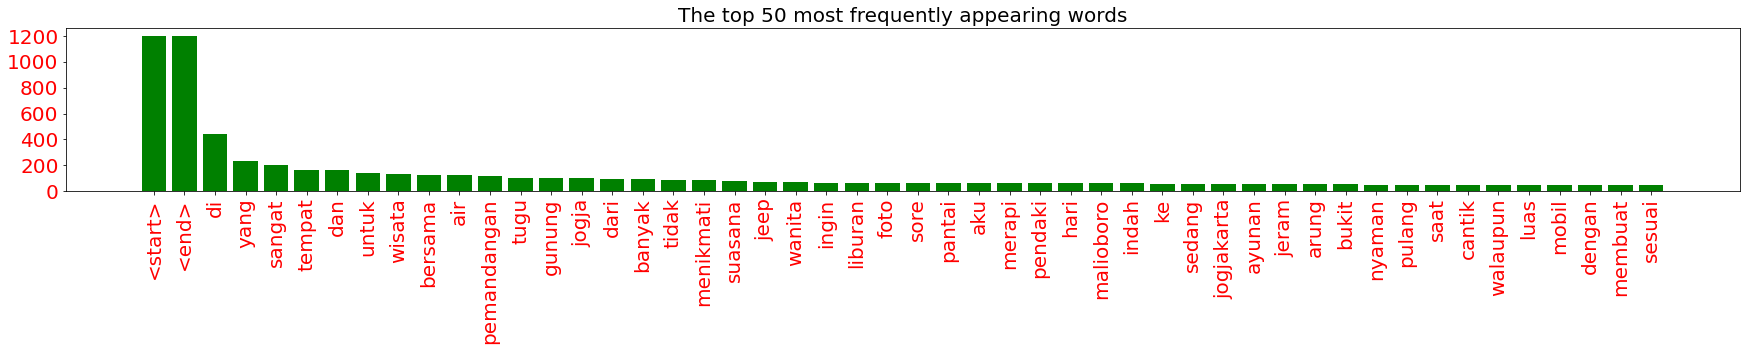

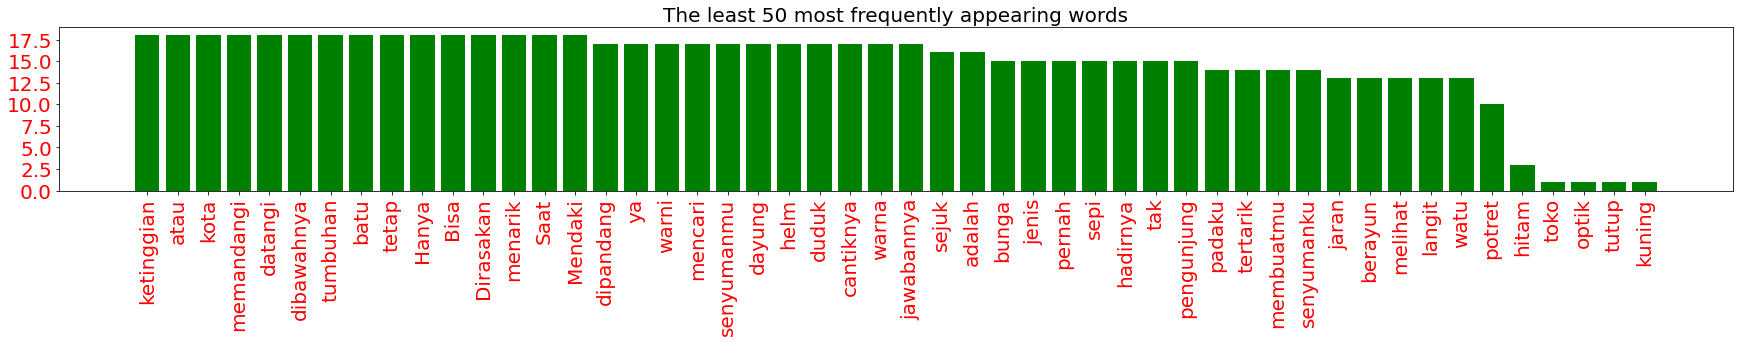

In [50]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [51]:
df

filename  \
0     /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
1     /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
2     /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
3     /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
4     /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
...                                                 ...   
1196  /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
1197  /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
1198  /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
1199  /home/yurio/mainan_yurio/img_cap_to_icitda/img...   
1200  /home/yurio/mainan_yurio/img_cap_to_icitda/img...   

                                                caption  
0     <start> berayun dan melihat pemandangan di ayu...  
1              <start> banyak tumbuhan dibawahnya <end>  
2     <start> bermain air juga sangat menyenangkan <...  
3     <start> pemandangan yang menawan dari bukit pa...  
4                     <start> serunya arung jeram <end>  
...                                                 ...  
1196  <start> di sekitar area monumen tugu jogjakart...  
1197        <start> malioboro, kamu dan kenangan. <end>  
1198  <start> pendaki wanita di saat mendaki gunung ...  
1199  <start> menikmati suasana pantai bersama kelua...  
1200  <start> potret pendaki cantik di atas gunung <...  

[1201 rows x 2 columns]

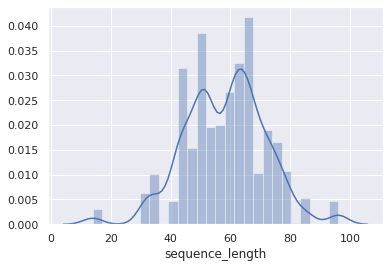

In [52]:
import seaborn as sns

# df=pd.DataFrame()
df["sequence_length"] = df["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

In [53]:
print(df.loc[0])
print(df.caption[0])
print(df.sequence_length[0])
print(len(df.caption[0]))

filename           /home/yurio/mainan_yurio/img_cap_to_icitda/img...
caption            <start> berayun dan melihat pemandangan di ayu...
sequence_length                                                   73
Name: 0, dtype: object
<start> berayun dan melihat pemandangan di ayunan langit watu jaran <end>
73
73


In [54]:
# !pip install seaborn

In [55]:
# Choose the top 5000 words from the vocabulary
top_k = 250
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [56]:
train_seqs[:5]

[[2, 206, 8, 207, 13, 4, 40, 208, 209, 210, 3],
 [2, 18, 166, 167, 3],
 [2, 117, 12, 63, 6, 118, 3],
 [2, 13, 5, 61, 19, 43, 79, 3],
 [2, 75, 41, 42, 3]]

In [57]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [58]:
tokenizer.index_word[0]

'<pad>'

In [59]:
tokenizer.oov_token

'<unk>'

In [60]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'di',
 5: 'yang',
 6: 'sangat',
 7: 'tempat',
 8: 'dan',
 9: 'untuk',
 10: 'wisata',
 11: 'bersama',
 12: 'air',
 13: 'pemandangan',
 14: 'tugu',
 15: 'jeep',
 16: 'jogja',
 17: 'gunung',
 18: 'banyak',
 19: 'dari',
 20: 'merapi',
 21: 'tidak',
 22: 'menikmati',
 23: 'suasana',
 24: 'malioboro',
 25: 'saat',
 26: 'wanita',
 27: 'ingin',
 28: 'liburan',
 29: 'foto',
 30: 'pantai',
 31: 'sore',
 32: 'aku',
 33: 'becak',
 34: 'pendaki',
 35: 'hari',
 36: 'indah',
 37: 'ke',
 38: 'sedang',
 39: 'jogjakarta',
 40: 'ayunan',
 41: 'arung',
 42: 'jeram',
 43: 'bukit',
 44: 'nyaman',
 45: 'pulang',
 46: 'cantik',
 47: 'walaupun',
 48: 'luas',
 49: 'mobil',
 50: 'dengan',
 51: 'mendaki',
 52: 'membuat',
 53: 'sesuai',
 54: 'pasangan',
 55: 'parangtritis',
 56: 'ibu',
 57: 'merah',
 58: 'heha',
 59: 'sky',
 60: 'view',
 61: 'menawan',
 62: 'yuk',
 63: 'juga',
 64: 'keluarga',
 65: 'terjun',
 66: 'sri',
 67: 'getuk',
 68: 'bisa',
 69: 'kamu',
 70: 'atas

In [61]:
tokenizer.word_counts

OrderedDict([('<start>', 1201),
             ('berayun', 13),
             ('dan', 160),
             ('melihat', 13),
             ('pemandangan', 117),
             ('di', 439),
             ('ayunan', 56),
             ('langit', 13),
             ('watu', 13),
             ('jaran', 13),
             ('<end>', 1201),
             ('banyak', 92),
             ('tumbuhan', 18),
             ('dibawahnya', 18),
             ('bermain', 21),
             ('air', 123),
             ('juga', 40),
             ('sangat', 201),
             ('menyenangkan', 21),
             ('yang', 232),
             ('menawan', 41),
             ('dari', 92),
             ('bukit', 52),
             ('paralayang', 35),
             ('serunya', 37),
             ('arung', 55),
             ('jeram', 55),
             ('menikmati', 84),
             ('ombak', 25),
             ('angin', 25),
             ('pantai', 64),
             ('parangtritis', 42),
             ('ibu', 42),
             ('sedang', 5

In [62]:
# print(tokenizer.word_index.items()[:5])
for i, (k,v) in enumerate(tokenizer.word_index.items()):
  print(i,k,v)
  if i == 10:
    break
# print(tokenizer.index_word.items()[:5])
print("-"*10)
for i, (k,v) in enumerate(tokenizer.index_word.items()):
  print(i,k,v)
  if i == 10:
    break

0 <unk> 1
1 <start> 2
2 <end> 3
3 di 4
4 yang 5
5 sangat 6
6 tempat 7
7 dan 8
8 untuk 9
9 wisata 10
10 bersama 11
----------
0 1 <unk>
1 2 <start>
2 3 <end>
3 4 di
4 5 yang
5 6 sangat
6 7 tempat
7 8 dan
8 9 untuk
9 10 wisata
10 11 bersama


In [63]:
len(tokenizer.word_index.items())

217

In [64]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [65]:
train_seqs[:5]

[[2, 206, 8, 207, 13, 4, 40, 208, 209, 210, 3],
 [2, 18, 166, 167, 3],
 [2, 117, 12, 63, 6, 118, 3],
 [2, 13, 5, 61, 19, 43, 79, 3],
 [2, 75, 41, 42, 3]]

In [66]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [67]:
cap_vector.shape

(1201, 15)

In [68]:
cap_vector[:5]

array([[  2, 206,   8, 207,  13,   4,  40, 208, 209, 210,   3,   0,   0,
          0,   0],
       [  2,  18, 166, 167,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2, 117,  12,  63,   6, 118,   3,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2,  13,   5,  61,  19,  43,  79,   3,   0,   0,   0,   0,   0,
          0,   0],
       [  2,  75,  41,  42,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [69]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [70]:
max_length

15

In [71]:
five_images = all_img_name_vector[:5]
unique_images = np.unique(five_images)
print(unique_images)

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/0cv1krzup6x45sq3i8hb.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/0jcymwz1atpn2fhi6s54.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/0y6txkj1b7eqmw9gpunc.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/1ho0rsaj76pnl4muibzy.jpg'
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/2b8e76qsg34umi9lxktc.jpg']


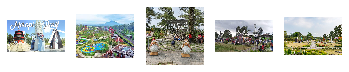

In [72]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(five_images):
    fig = figure()
    number_of_files = len(five_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(five_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

showImagesHorizontally(unique_images)

In [73]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(train_captions)))

Total Images : 1201
Total Captions : 1201


## Split the data into training and testing

In [74]:
len(img_name_vector)

1201

In [75]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.25,
                                                                    random_state=0)

In [76]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(900, 900, 301, 301)

In [77]:
img_name_train[:5]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/irjd9k5ofle4u8sc2mpa.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/bjuxyd5kz3tqcgp1simr.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/hz7aenruy2ogm5f3ktiw.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/7kt0uypdofagiwmxnscv.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/uodick0mgz8enxwas1tj.jpg']

In [78]:
cap_train[:5]

array([[  2,   6,  44,   9,  97,  98,  21,  99,  45,   3,   0,   0,   0,
          0,   0],
       [  2, 153,  18, 154,   5,  52,   6,  61,   3,   0,   0,   0,   0,
          0,   0],
       [  2, 117,  12,  63,   6, 118,   3,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2, 127, 128,  72,   9, 129,   3,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  2,  82,  81, 195,   8, 196, 197, 198,  21,  83, 199,   3,   0,
          0,   0]], dtype=int32)

In [79]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[-1],img.shape))

In [80]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [81]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> a7tcz1l0rkojxv3sf4em.jpg is ==> (937, 750, 3)
Shape of the image ==> 3p1cgrahe4qitw0kf6du.jpeg is ==> (225, 225, 3)
Shape of the image ==> hz7aenruy2ogm5f3ktiw.jpg is ==> (810, 1080, 3)
Shape of the image ==> n9df1iy70p8ljverh4tz.jpg is ==> (682, 1024, 3)
Shape of the image ==> 9bli6p2ya58udrc01fh3.jpg is ==> (195, 300, 3)
Shape of the image ==> 0kfe159hl6dt8yzwsn3o.jpg is ==> (640, 960, 3)
Shape of the image ==> 3m9ju6kr2sdegbyn7fz5.jpg is ==> (600, 1066, 3)
Shape of the image ==> Jalan-Malioboro-2.jpg is ==> (1350, 1080, 3)
Shape of the image ==> 67anzchivkr489ef13bj.jpg is ==> (589, 900, 3)
Shape of the image ==> 3wpdih18lme49yqtbuz2.jpg is ==> (533, 800, 3)
Shape of the image ==> ha1wsvigtzc8nly40r6p.jpg is ==> (960, 768, 3)
Shape of the image ==> crm8fx2n1jedi3t7l4h6.jpg is ==> (450, 600, 3)
Shape of the image ==> do4cuepvy5zwij7rxfk8.jpg is ==> (183, 276, 3)
Shape of the image ==> v73zhljofqpbc2m8r5iu.jpg is ==> (960, 640, 3)
Shape of the image ==> f9687i34

Shape of the image:(479, 480, 3)


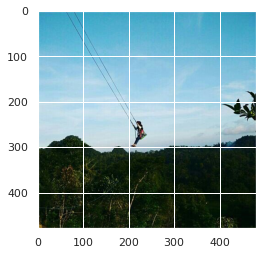

In [82]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/uzd0vngkpsbw9c6e7q5y.jpg')

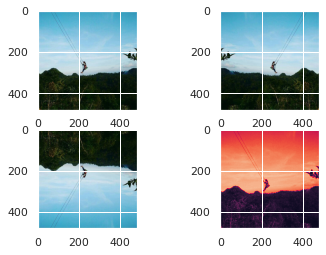

In [83]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)

image_flipper('/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/uzd0vngkpsbw9c6e7q5y.jpg')

In [84]:
# !pip install imageio

In [85]:
# def load_npy(img_name, cap):
#   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
#   return img_tensor, cap

In [86]:
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)   # [1, 2], [3, 4]
ds

<TensorSliceDataset shapes: (2,), types: tf.int32>

In [87]:
t.numpy()

array([[1, 2],
       [3, 4]], dtype=int32)

In [88]:
t.numpy().shape

(2, 2)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [89]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE  # 384 / 64

In [90]:
num_steps

14

In [91]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [92]:
# img_name_train, img_name_val, cap_train, cap_val
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [93]:
print(dataset)
print(test_dataset)

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>


## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [94]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # vector_size 512 + vector_size 512

    # attention_weights shape == (batch_size, 64, 1) # from 512 --> 1 fc
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    print("attention_weights: ",attention_weights)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features # dot_prod feature x attention
    context_vector = tf.reduce_sum(context_vector, axis=1) # vector sum

    return context_vector, attention_weights

In [95]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [96]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
#     self.gru = tf.compat.v1.keras.layers.CuDNNLSTM(self.units, 
#                                         return_sequences=True, 
#                                         return_state=True, 
#                                         recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [97]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [98]:
print(encoder)
print(decoder)

In [99]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [100]:
# del ckpt

In [101]:
checkpoint_path = PATH + "/checkpoints/inceptionV3"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [102]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [103]:
! mkdir ./logs
! mkdir ./logs/inceptionV3

In [104]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [105]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/inceptionV3/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/inceptionV3/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [106]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [107]:
@tf.function
def train_step(img_tensor, target): # input from img tensor, n target word captions
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # decide input
  
  print("target.shape[0]: ", target.shape[0])
  print("dec_input: ", dec_input)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)  # 64 x 256
      print("target.shape[1]: ", target.shape[1])

      for i in range(1, target.shape[1]): # loop over the target
          # passing the features through the decoder
          # overwrite hidden from attention
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          print(i)

          loss += loss_function(target[:, i], predictions)
          print("target[:, i]: ", target[:, i])

          # using teacher forcing # overwrite new decide_input
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [108]:
test_loss_plot = []

In [109]:
@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder
     
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
#       predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#       dec_input = tf.expand_dims([predicted_id]*target.shape[0], 1)
      dec_input = tf.expand_dims(target[:, i], 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [110]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    
    
    #For Train
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)
    
    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)
        
    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

target.shape[0]:  64
dec_input:  Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
target.shape[1]:  15
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_1:0", shape=(64, 64, 1), dtype=float32)
1
target[:, i]:  Tensor("strided_slice_1:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_3:0", shape=(64, 64, 1), dtype=float32)
2
target[:, i]:  Tensor("strided_slice_4:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_5:0", shape=(64, 64, 1), dtype=float32)
3
target[:, i]:  Tensor("strided_slice_7:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_7:0", shape=(64, 64, 1), dtype=float32)
4
target[:, i]:  Tensor("strided_slice_10:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_9:0", shape=(64, 64, 1), dtype=float32)
5
target[:, i]:  Tensor("strided_slice_13:0", shape=(64,), d

attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_7:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_9:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_11:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_13:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_15:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_17:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_19:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_21:0", shape=(64, 64, 1), dtype=float32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_23:0", shape=(64, 64, 1), dtype=float32)
att

In [111]:
%load_ext tensorboard
%tensorboard --logdir logs/inceptionV3/gradient_tape

Reusing TensorBoard on port 6007 (pid 48223), started 1:08:49 ago. (Use '!kill 48223' to kill it.)

In [112]:
ckpt_manager.checkpoints

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/inceptionV3/ckpt-1',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/inceptionV3/ckpt-2',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/inceptionV3/ckpt-3',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/inceptionV3/ckpt-4',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/checkpoints/inceptionV3/ckpt-5']

In [234]:
ckpt.restore('./checkpoints/inceptionV3/ckpt-5')

No handles with labels found to put in legend.


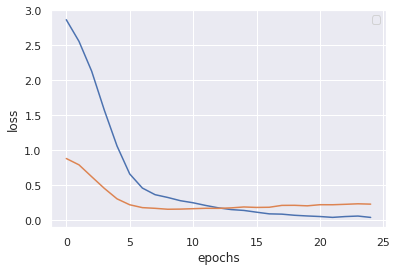

In [235]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [214]:
## greedy search
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
#         predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [215]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

attention_weights:  tf.Tensor(
[[[7.14723355e-05]
  [6.51158844e-05]
  [5.06329052e-05]
  [5.65842383e-05]
  [6.27067857e-05]
  [5.64158581e-05]
  [2.62577869e-05]
  [1.64173071e-05]
  [1.10304660e-04]
  [8.86268754e-05]
  [1.40059201e-04]
  [1.57946270e-04]
  [1.88090315e-04]
  [9.83114951e-05]
  [2.87910771e-05]
  [1.49611351e-05]
  [6.56695454e-04]
  [4.97321505e-03]
  [5.86586772e-03]
  [3.86705762e-03]
  [1.03759253e-02]
  [9.19577293e-03]
  [5.44016366e-04]
  [1.89418890e-04]
  [2.86202272e-03]
  [1.71425045e-02]
  [1.28533300e-02]
  [6.99952571e-03]
  [1.03507470e-02]
  [1.32920425e-02]
  [1.14929741e-02]
  [2.95040733e-03]
  [6.70562126e-03]
  [2.26826612e-02]
  [2.65317690e-02]
  [1.50039159e-02]
  [2.84523275e-02]
  [2.27734353e-02]
  [4.19362448e-02]
  [3.42927761e-02]
  [1.50447374e-03]
  [1.13060661e-02]
  [2.46594884e-02]
  [1.68476831e-02]
  [2.10467651e-02]
  [2.92239394e-02]
  [3.24724838e-02]
  [3.67118455e-02]
  [5.69432275e-04]
  [1.19566568e-03]
  [2.18951516e-02]


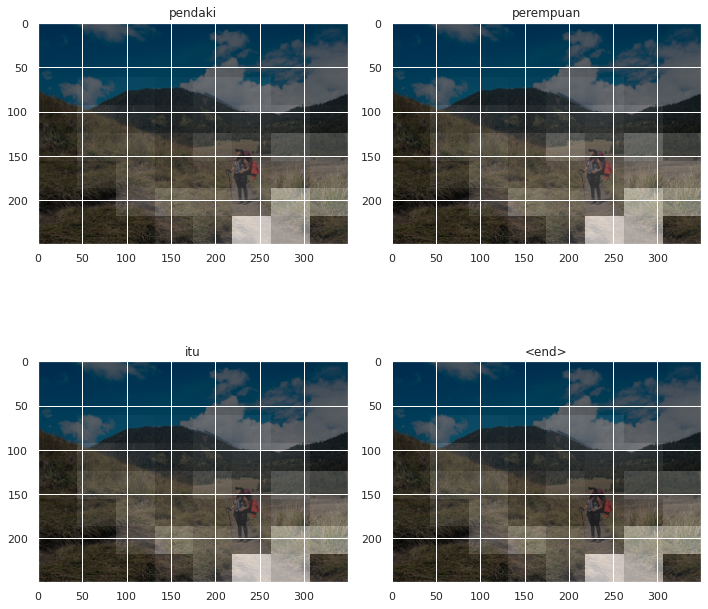

In [217]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [177]:
# # ## Beam Search
# def evaluate(image, beam_index = 3):

#     start = [tokenizer.word_index['<start>']]
    
#     # result[0][0] = index of the starting word
#     # result[0][1] = probability of the word predicted
#     result = [[start, 0.0]]

#     attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)

#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

#     features = encoder(img_tensor_val)

#     dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

#     while len(result[0][0]) < max_length:
#         i=0
#         temp = []
#         for s in result:

#           predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

#           attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
#           i=i+1
#           # Getting the top <beam_index>(n) predictions
#           word_preds = np.argsort(predictions[0])[-beam_index:]
          
#           # creating a new list so as to put them via the model again
#           for w in word_preds:       
#             next_cap, prob = s[0][:], s[1]
#             next_cap.append(w)
#             prob += predictions[0][w]
#             temp.append([next_cap, prob])
#         result = temp
#         # Sorting according to the probabilities
#         result = sorted(result, reverse=False, key=lambda l: l[1])
#         # Getting the top words
#         result = result[-beam_index:]
        
#         predicted_id = result[-1] # with Max Probability
#         pred_list = predicted_id[0]
        
#         prd_id = pred_list[-1] 
#         if(prd_id!=3):
#           dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
#         else:
#           break

#     result = result[-1][0]
    
#     intermediate_caption = [tokenizer.index_word[i] for i in result]
#     final_caption = []
#     for i in intermediate_caption:
#         if i != '<end>':
#             final_caption.append(i)
            
#         else:
#             break

#     attention_plot = attention_plot[:len(result), :]
#     final_caption = ' '.join(final_caption[1:])
#     return final_caption,attention_plot

In [120]:
##

/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/6pcmugnf8ixj1k30zrao.jpg
[  2 125  37  17  62  11  32 126  32   3   0   0   0   0   0]
<start> main ke gunung yuk bersama aku iya aku <end>


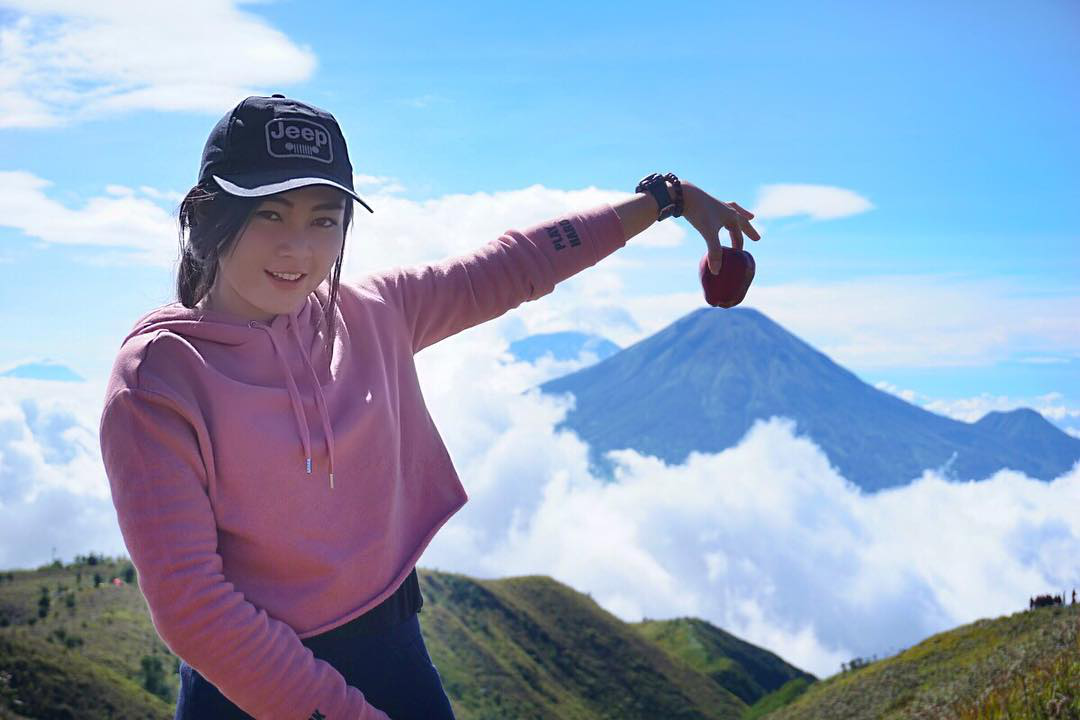

In [187]:
# ### Greedy Search
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

# taking random picture
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
print(cap_val[rid])

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
print(real_caption)
Image.open(img_name_val[rid])

In [188]:
# counting time
# start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('this is result: ', result)
print('this is attention_plot: ', attention_plot)

attention_weights:  tf.Tensor(
[[[2.99558997e-05]
  [2.54879142e-05]
  [9.13857366e-05]
  [2.37928780e-05]
  [1.01843405e-04]
  [1.65818303e-04]
  [1.13098213e-04]
  [6.60786929e-04]
  [5.71704404e-05]
  [3.91098183e-05]
  [1.33201783e-03]
  [1.49628599e-04]
  [1.51511095e-02]
  [6.33537769e-03]
  [5.22475515e-04]
  [2.26780045e-04]
  [4.83438809e-04]
  [1.09250665e-04]
  [9.05786268e-03]
  [2.98510958e-03]
  [3.64262849e-01]
  [1.97226003e-01]
  [4.62231524e-02]
  [1.22998856e-04]
  [2.33964194e-04]
  [1.94505672e-04]
  [1.31131860e-03]
  [2.69096403e-04]
  [2.13269945e-04]
  [9.97812240e-05]
  [4.14912589e-04]
  [4.58916402e-05]
  [7.93345214e-04]
  [7.01029645e-03]
  [2.00394150e-02]
  [9.93022602e-03]
  [1.82106055e-03]
  [1.21084787e-03]
  [1.54343434e-03]
  [4.98667825e-04]
  [1.77006738e-03]
  [1.75783873e-01]
  [5.79917198e-03]
  [3.20364395e-03]
  [7.70360522e-04]
  [1.03313907e-03]
  [1.24766503e-03]
  [5.67559269e-04]
  [2.19209382e-04]
  [1.23608054e-03]
  [4.92226623e-04]


In [189]:
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

print(first)
print(real_caption)

main ke gunung yuk bersama aku iya aku <end>
main ke gunung yuk bersama aku iya aku


In [ ]:
#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

In [190]:
#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]
print(result_join)
print(result_final)

tempat yang menawan dari bukit yang hanya bisa saja tangguh <end>
tempat yang menawan dari bukit yang hanya bisa saja tangguh


In [192]:
real_appn = []
real_appn.append(real_caption.split())
reference = real_caption.split()
candidate = result_final.split()

print(real_appn)
print(reference)
print(candidate)

[['main', 'ke', 'gunung', 'yuk', 'bersama', 'aku', 'iya', 'aku']]
['main', 'ke', 'gunung', 'yuk', 'bersama', 'aku', 'iya', 'aku']
['tempat', 'yang', 'menawan', 'dari', 'bukit', 'yang', 'hanya', 'bisa', 'saja', 'tangguh']


BLEU score: 0
Real Caption: main ke gunung yuk bersama aku iya aku
Prediction Caption: tempat yang menawan dari bukit yang hanya bisa saja tangguh


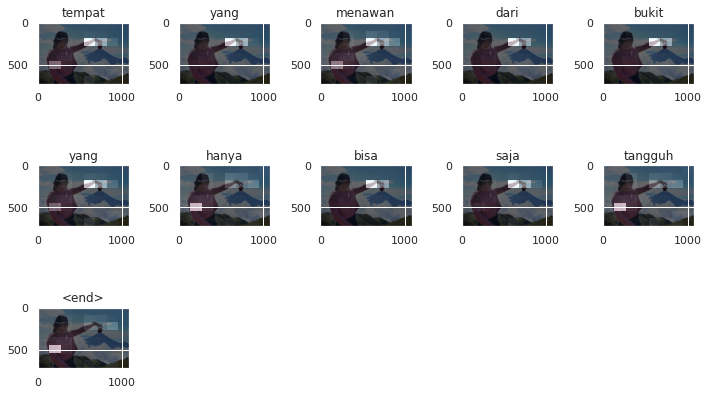

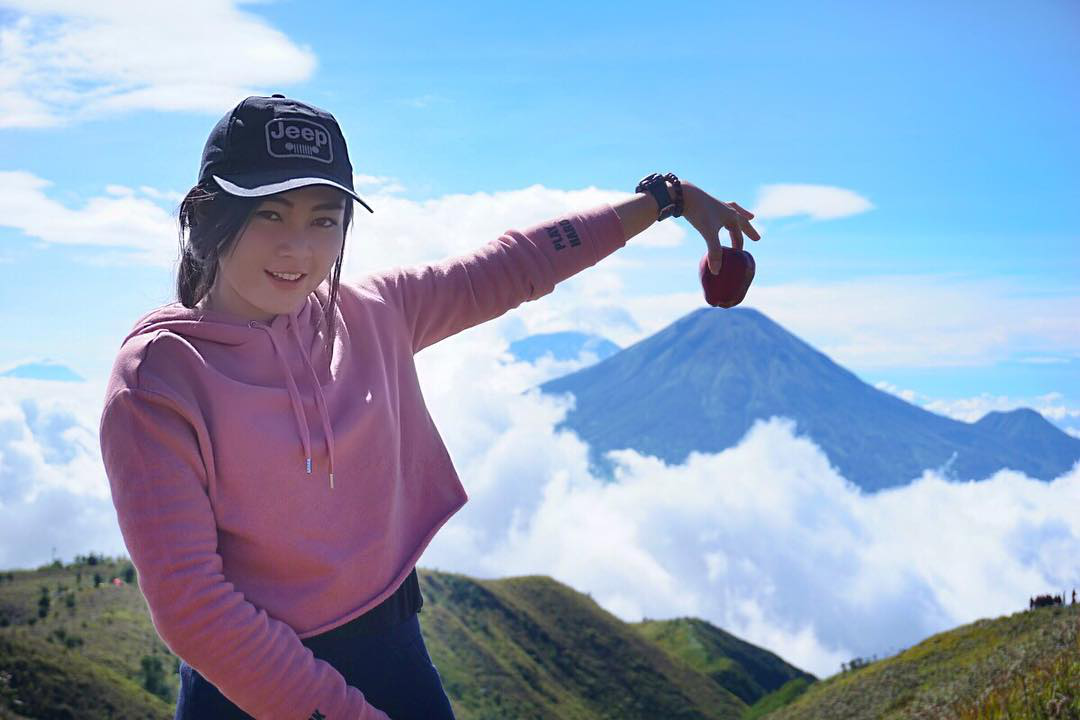

In [193]:
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)

# print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/2n4yb6wti3amhcd1qzp0.jpg
[ 2 10 20 85 86 15 87 88  3  0  0  0  0  0  0]
attention_weights:  tf.Tensor(
[[[5.01614124e-07]
  [3.31994920e-06]
  [5.43907447e-07]
  [1.43042115e-07]
  [2.93187242e-07]
  [2.12090526e-07]
  [3.11955901e-08]
  [5.01647399e-08]
  [2.08554320e-06]
  [2.38139855e-05]
  [1.11844374e-05]
  [1.15999842e-06]
  [1.89069760e-06]
  [3.49447845e-07]
  [1.17541774e-07]
  [9.84738406e-08]
  [2.55070944e-07]
  [1.01629976e-05]
  [7.84581789e-05]
  [4.03834973e-04]
  [6.13258337e-04]
  [6.47819434e-06]
  [8.14994053e-07]
  [2.99628908e-07]
  [1.89295552e-05]
  [1.10971252e-03]
  [4.14965190e-02]
  [1.13565817e-01]
  [1.97356358e-01]
  [5.49388165e-03]
  [5.59735461e-04]
  [8.26014184e-06]
  [4.49548861e-05]
  [4.48532216e-03]
  [1.36010870e-01]
  [4.93895561e-02]
  [4.40363660e-02]
  [3.74003313e-03]
  [8.35931161e-04]
  [6.68937582e-06]
  [1.29704022e-05]
  [1.12709659e-03]
  [3.83

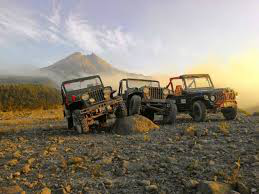

In [237]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

# taking random picture
rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
print(image)
print(cap_train[rid])

# counting time
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()
print("reference: ", reference)
print("candidate: ", candidate)

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

# plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_train[rid])

/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_inception_v3/f9687i34s5gpejrly0zm.jpg
[ 2 13  5 61 19 43 79  3  0  0  0  0  0  0  0]
attention_weights:  tf.Tensor(
[[[1.97654231e-06]
  [9.46494492e-06]
  [3.75498757e-06]
  [5.95182155e-06]
  [1.83146642e-06]
  [1.58082651e-06]
  [1.35904986e-06]
  [1.64581288e-05]
  [1.40570523e-06]
  [1.28099664e-05]
  [1.93672240e-04]
  [2.42796687e-05]
  [2.39137921e-06]
  [2.14933584e-06]
  [1.99944611e-06]
  [1.37767865e-05]
  [1.54099616e-05]
  [5.09105530e-03]
  [6.23520762e-02]
  [2.50335149e-02]
  [1.46735038e-04]
  [8.17431214e-07]
  [8.35484400e-07]
  [3.00232614e-06]
  [1.20133416e-04]
  [5.49496934e-02]
  [2.09360346e-01]
  [7.65339956e-02]
  [3.15276086e-02]
  [5.26749063e-05]
  [2.09719110e-06]
  [3.32930199e-06]
  [9.35774879e-05]
  [5.06550521e-02]
  [3.58139008e-01]
  [1.49399592e-02]
  [2.66709458e-02]
  [6.92024914e-05]
  [9.87651674e-07]
  [1.23237430e-06]
  [1.18078160e-05]
  [1.07166055e-03]
  [1.57

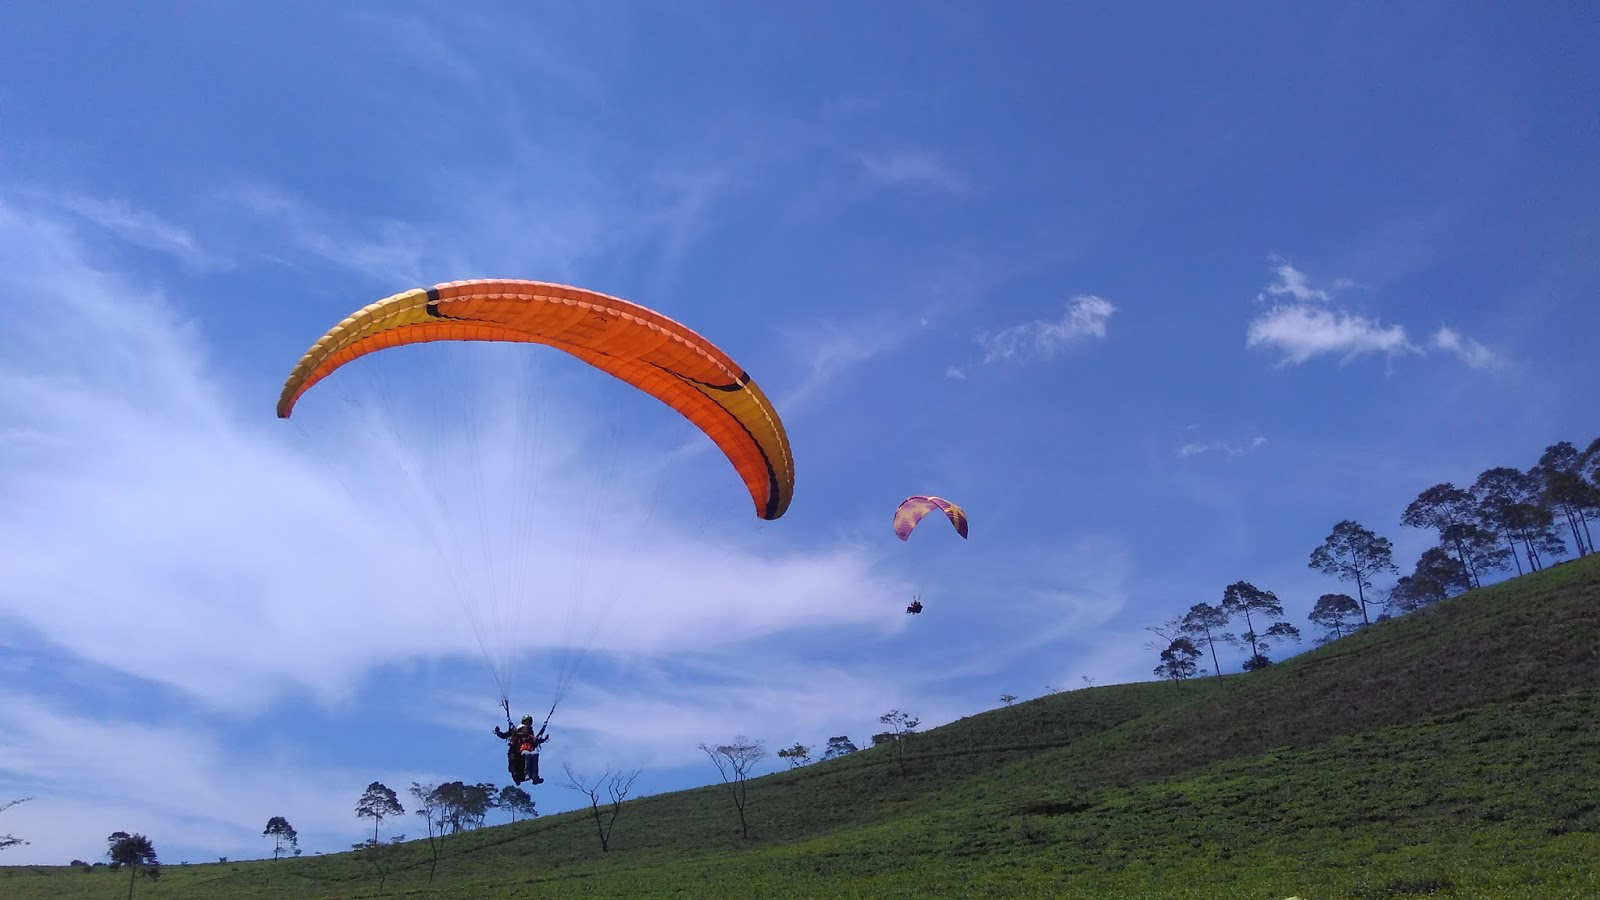

In [239]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

# taking random picture
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
print(cap_val[rid])

# counting time
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()
print("reference: ", reference)
print("candidate: ", candidate)

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

# plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC5.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC4.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC3.JPG'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC2.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC1.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.